In [14]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import NearestNeighbors

import hdbscan
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import shutil
import os

In [15]:
# Load data
df = pd.read_csv("../data/features.csv")
df2 = pd.read_csv("../data/features_before.csv")

# Separate metadata and features
file_names = df["file_name"]
X = df.drop(columns=["file_name"])
X2 = df2.drop(columns=["file_name"])

# Scale + (optional) remove near-constant features
X_scaled = StandardScaler().fit_transform(X)
X2_scaled = StandardScaler().fit_transform(X2)

# X_scaled = VarianceThreshold(threshold=1e-3).fit_transform(X_scaled)

In [16]:
def diffusion_map_embedding(X, n_neighbors=30, n_components=2, t=1):
    """
    Diffusion Maps embedding using a kNN Gaussian kernel.
    Returns embedding of shape (n_samples, n_components) and the leading eigenspectrum.
    """
    n = X.shape[0]

    # kNN distances/indices
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
    nn.fit(X)
    dists, idx = nn.kneighbors(X)

    # Kernel bandwidth: median distance to the k-th neighbor (robust default)
    sigma = np.median(dists[:, -1])
    if sigma <= 0:
        raise ValueError("Estimated sigma <= 0; check your data scaling.")

    # Build sparse-ish affinity in dense matrix form (n is small for you ~446)
    W = np.zeros((n, n), dtype=float)
    for i in range(n):
        for jpos in range(1, n_neighbors):  # skip self at position 0
            j = idx[i, jpos]
            d = dists[i, jpos]
            w = np.exp(-(d * d) / (sigma * sigma))
            W[i, j] = w

    # Symmetrize (important)
    W = np.maximum(W, W.T)

    # Row-normalize to Markov matrix P = D^{-1} W
    D = W.sum(axis=1)
    D[D == 0] = 1.0
    P = (W.T / D).T

    # Symmetric normalization for stable eigen-decomposition:
    # A = D^{1/2} P D^{-1/2} = D^{-1/2} W D^{-1/2}
    D_sqrt_inv = 1.0 / np.sqrt(D)
    A = (D_sqrt_inv[:, None] * W) * D_sqrt_inv[None, :]

    # Eigen-decomposition (A is symmetric)
    evals, evecs = np.linalg.eigh(A)
    order = np.argsort(evals)[::-1]
    evals, evecs = evals[order], evecs[:, order]

    # Convert back to diffusion eigenvectors of P
    psi = evecs * D_sqrt_inv[:, None]

    # Diffusion coordinates: psi_k * (lambda_k^t), skipping trivial first component
    lambdas = evals[1:n_components + 1]
    coords = psi[:, 1:n_components + 1] * (lambdas ** t)

    return coords, evals


X_diff, evals = diffusion_map_embedding(
    X_scaled,
    n_neighbors=30,
    n_components=2,
    t=1
)

X2_diff, evals2 = diffusion_map_embedding(
    X2_scaled,
    n_neighbors=30,
    n_components=2,
    t=1
)

print("Top diffusion eigenvalues (first 10):", evals[:10])
print("Top diffusion eigenvalues (first 10) for previous features:", evals2[:10])

Top diffusion eigenvalues (first 10): [1.         0.97449888 0.92130451 0.90736923 0.86950719 0.84756695
 0.8352078  0.82427407 0.75743156 0.74065033]
Top diffusion eigenvalues (first 10) for previous features: [1.         0.98393619 0.93712902 0.90817151 0.89604535 0.87161376
 0.8511386  0.8323226  0.77410178 0.72549838]


In [17]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=17,
    min_samples=8,
    metric="euclidean"
)

labels = clusterer.fit_predict(X_diff)
labels2 = clusterer.fit_predict(X2_diff)
df["cluster"] = labels


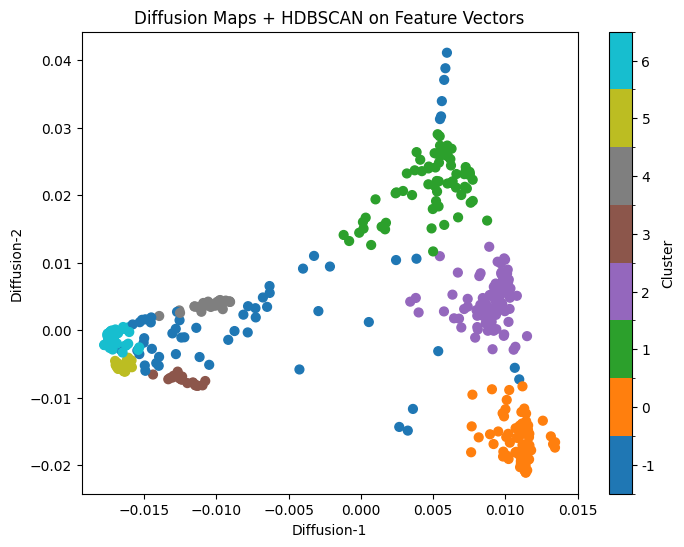

In [18]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
label_indices = np.array([label_to_index[l] for l in labels])

cmap = plt.get_cmap("tab10", len(unique_labels))
bounds = np.arange(len(unique_labels) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.scatter(
    X_diff[:, 0],
    X_diff[:, 1],
    c=label_indices,
    cmap=cmap,
    norm=norm,
    s=40
)
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_ticklabels(unique_labels)
cbar.set_label("Cluster")
plt.title("Diffusion Maps + HDBSCAN on Feature Vectors")
plt.xlabel("Diffusion-1")
plt.ylabel("Diffusion-2")
plt.show()


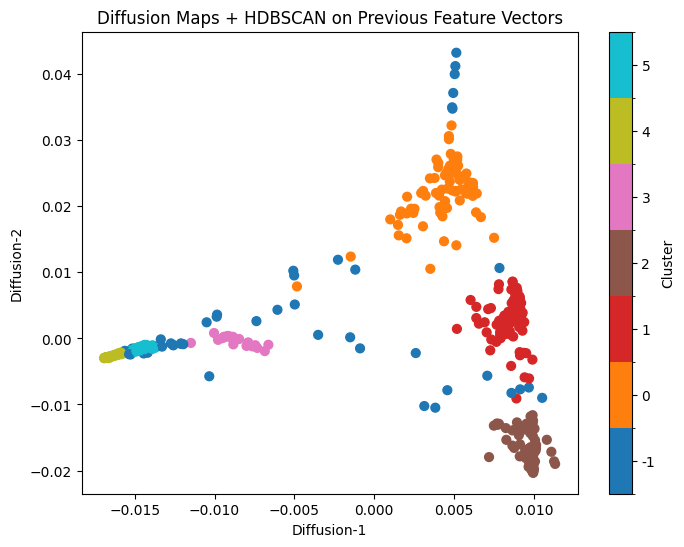

In [19]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels2)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
label2_indices = np.array([label_to_index[l] for l in labels2])

cmap = plt.get_cmap("tab10", len(unique_labels))
bounds = np.arange(len(unique_labels) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.scatter(
    X2_diff[:, 0],
    X2_diff[:, 1],
    c=label2_indices,
    cmap=cmap,
    norm=norm,
    s=40
)
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_ticklabels(unique_labels)
cbar.set_label("Cluster")
plt.title("Diffusion Maps + HDBSCAN on Previous Feature Vectors")
plt.xlabel("Diffusion-1")
plt.ylabel("Diffusion-2")
plt.show()

In [20]:
# Get unique clusters and get 5 representative samples from each cluster
representative_samples = []
for cluster in np.unique(labels):
    cluster_samples = df[df["cluster"] == cluster]
    representative_samples.append(cluster_samples.sample(n=5, random_state=42))
    print(f"Cluster {cluster}:")
    print(cluster_samples["file_name"].values[:5])  # Print first 5 file names from this cluster
    
    # Get the rep samples from visuals/ boiling_plots and save to new folder visuals/repsamples/DIFF-HDBSCAN in subfolders by cluster
    for file in cluster_samples["file_name"].values[:5]:
        # remove.csv and add .png to get the corresponding plot file
        file = file.replace(".csv", ".png")
        src = f"../visuals/boiling_plots/{file}"
        dst = f"../visuals/rep_samples/DIFF-HDBSCAN/{cluster}/{file}"
        # Create the destination directory if it doesn't exist
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

Cluster -1:
['Boiling_at_Heater_T85_RefVideo1.csv'
 'Boiling_at_Heater_T93_RefVideo2.csv'
 'MATLAB 1-04 PM Thu, Aug 22, 2024 Run2.csv'
 'MATLAB 1-07 PM Fri, Jun 14, 2024 Run1 .csv'
 'MATLAB 1-14 PM Tue, Sep 10, 2024 Run10 .csv']
Cluster 0:
['Calm_to_Boiling_50V_on_StartT65.csv'
 'MATLAB 1-21 PM Thu, Nov 7, 2024 Run10 .csv'
 'MATLAB 1-25 PM Thu, Nov 7, 2024 Run11 .csv'
 'MATLAB 1-29 PM Thu, Nov 7, 2024 Run12 .csv'
 'MATLAB 1-32 PM Thu, Nov 7, 2024 Run13 .csv']
Cluster 1:
['MATLAB 1-00 PM Thu, Aug 22, 2024 Run1.csv'
 'MATLAB 1-04 PM Tue, Sep 10, 2024 Run9 .csv'
 'MATLAB 1-05 PM Thu, Aug 22, 2024 Run3 .csv'
 'MATLAB 1-10 PM Thu, Aug 22, 2024 Run4 .csv'
 'MATLAB 1-15 PM Thu, Aug 22, 2024 Run5 .csv']
Cluster 2:
['MATLAB 1-00 PM Fri, Jun 28, 2024 Run8 .csv'
 'MATLAB 1-02 PM Thu, Nov 7, 2024 Run8 .csv'
 'MATLAB 1-07 PM Fri, May 31, 2024 Run3 .csv'
 'MATLAB 1-12 PM Thu, Nov 7, 2024 Run9 .csv'
 'MATLAB 1-17 PM Tue, Sep 10, 2024 Run11 .csv']
Cluster 3:
['MATLAB 1-02 PM Mon, Mar 11, 2024 Run4 .cs